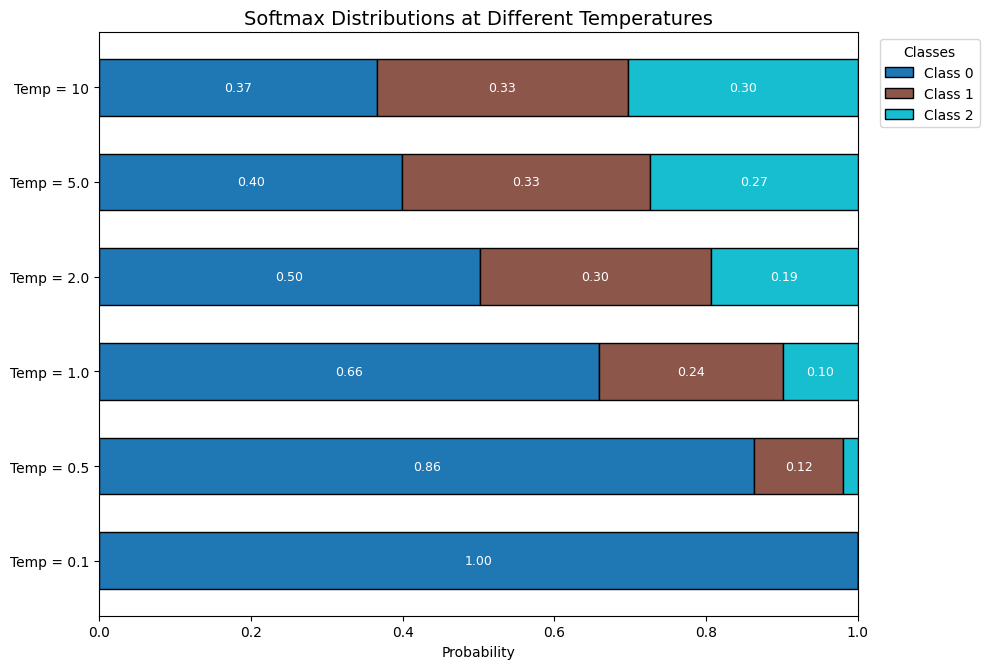

: 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

def softmax(logits, temperature=1.0):
    logits = np.array(logits)
    scaled_logits = logits / temperature
    exp_logits = np.exp(scaled_logits - np.max(scaled_logits))
    return exp_logits / np.sum(exp_logits)

# Example logits and temperature values
logits = [2.0, 1.0, 0.1]
temperatures = [0.1, 0.5, 1.0, 2.0, 5.0, 10]

num_classes = len(logits)
colors = cm.tab10(np.linspace(0, 1, num_classes))

# Set up figure
fig, ax = plt.subplots(figsize=(10, 2 + len(temperatures) * 0.8))

for i, temp in enumerate(temperatures):
    probs = softmax(logits, temperature=temp)
    left = 0
    for j, prob in enumerate(probs):
        ax.barh(y=i, width=prob, left=left, color=colors[j], edgecolor='black', height=0.6)
        if prob > 0.05:
            ax.text(left + prob / 2, i, f'{prob:.2f}', ha='center', va='center', color='white', fontsize=9)
        left += prob

# Set ticks and labels
ax.set_yticks(range(len(temperatures)))
ax.set_yticklabels([f"Temp = {t}" for t in temperatures])
ax.set_xlim(0, 1)
ax.set_xlabel("Probability")
ax.set_title("Softmax Distributions at Different Temperatures", fontsize=14)

# Add legend for class colors
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=colors[i], edgecolor='black', label=f'Class {i}') for i in range(num_classes)]
ax.legend(handles=legend_elements, title="Classes", bbox_to_anchor=(1.02, 1), loc="upper left")

plt.tight_layout()
plt.show()


In [3]:
import torch
@torch.jit.script
def beam_search(log_probs: torch.Tensor, beam_size: int):
    """
    Performs beam search on a tensor of log probabilities.

    Args:
        log_probs (torch.Tensor): Tensor of shape (b, t, v) containing log probabilities.
        beam_size (int): Number of beams to keep at each time step.

    Returns:
        sequences (torch.Tensor): Tensor of shape (b, beam_size, t) containing the top sequences.
        scores (torch.Tensor): Tensor of shape (b, beam_size) containing the scores of the top sequences.
    """
    
    b, t, v = log_probs.size()
    
    initial_beam_size = min(beam_size, v) # At the very first step (time step 0), we can't have more beams than the vocabulary size. This line ensures that the initial number of beams considered doesn't exceed the number of possible first tokens.

    topk_scores, topk_indices = torch.topk(log_probs[:, 0, :], initial_beam_size, dim=-1) # Returns the k largest elements of the given input tensor along a given dimension
    sequences = topk_indices.unsqueeze(-1)  # (b, initial_beam_size, 1)
    scores = topk_scores  # (b, initial_beam_size)

    for step in range(1, t):
        # Expand the current sequences with all possible next tokens
        current_log_probs = log_probs[:, step, :].unsqueeze(1)  # (b, 1, v)
        expanded_scores = scores.unsqueeze(-1) + current_log_probs  # (b, beam_size, v)
        flat_scores = expanded_scores.view(b, -1)  # (b, beam_size * v)

        # Select the top-k scores and their corresponding indices
        topk_flat_scores, topk_indices = flat_scores.topk(beam_size, dim=-1)  # (b, beam_size)
        beam_indices = topk_indices // v  # Indices of sequences to expand
        token_indices = topk_indices % v  # New tokens to append

        # Gather the sequences to expand and append the new tokens
        sequences = torch.gather(sequences, 1, beam_indices.unsqueeze(-1).expand(-1, -1, sequences.size(-1)))
        sequences = torch.cat([sequences, token_indices.unsqueeze(-1)], dim=-1)  # (b, beam_size, step+1)

        # Update the scores
        scores = topk_flat_scores

    return sequences, scores.unsqueeze(-1)



In [4]:
batch_size = 2
sequence_length = 5
vocab_size = 3
beam_size = 2

# Simulate log probabilities
log_probs = torch.randn(batch_size, sequence_length, vocab_size).log_softmax(dim=-1)
device = torch.device('cpu')
log_probs = log_probs.to(device)


In [5]:
log_probs[1,3:,:] = -float("1000000")

In [6]:
log_probs

tensor([[[-1.8899e+00, -2.1070e+00, -3.1842e-01],
         [-2.1674e+00, -1.9027e-01, -2.8338e+00],
         [-8.3714e-01, -1.0544e+00, -1.5203e+00],
         [-3.4578e+00, -8.0920e-01, -6.4763e-01],
         [-1.3894e+00, -8.6925e-01, -1.1041e+00]],

        [[-7.3432e-01, -9.6095e-01, -1.9831e+00],
         [-2.7039e+00, -1.2710e+00, -4.2692e-01],
         [-1.5526e+00, -2.4944e+00, -3.4848e-01],
         [-1.0000e+06, -1.0000e+06, -1.0000e+06],
         [-1.0000e+06, -1.0000e+06, -1.0000e+06]]])

In [7]:
# Perform beam search
sequences, scores = beam_search(log_probs, beam_size)

print("Top sequences:", sequences) # bsz, beamsize,seq_len
print("Scores:", scores) # bsz, beamsize,1

Top sequences: tensor([[[2, 1, 0, 2, 1],
         [2, 1, 0, 1, 1]],

        [[0, 2, 2, 0, 0],
         [0, 2, 2, 0, 2]]])
Scores: tensor([[[-2.8627e+00],
         [-3.0243e+00]],

        [[-2.0000e+06],
         [-2.0000e+06]]])


In [8]:
sequences.shape, scores.shape

(torch.Size([2, 2, 5]), torch.Size([2, 2, 1]))

In [9]:
path_probs = torch.gather(log_probs, 2, sequences.transpose(1,2)).transpose(1,2) # bsz, beamsize, T
path_probs

tensor([[[-3.1842e-01, -1.9027e-01, -8.3714e-01, -6.4763e-01, -8.6925e-01],
         [-3.1842e-01, -1.9027e-01, -8.3714e-01, -8.0920e-01, -8.6925e-01]],

        [[-7.3432e-01, -4.2692e-01, -3.4848e-01, -1.0000e+06, -1.0000e+06],
         [-7.3432e-01, -4.2692e-01, -3.4848e-01, -1.0000e+06, -1.0000e+06]]])

In [10]:
mean = scores.mean(dim=1, keepdim=True)
std = scores.std(dim=1, keepdim=True)

scores = (scores - mean) / std

In [11]:
path_probs*scores

tensor([[[-0.2252, -0.1345, -0.5919, -0.4579, -0.6147],
         [ 0.2252,  0.1345,  0.5919,  0.5722,  0.6147]],

        [[    nan,     nan,     nan,     nan,     nan],
         [    nan,     nan,     nan,     nan,     nan]]])

In [12]:
sequences # bsz,beam,T

tensor([[[2, 1, 0, 2, 1],
         [2, 1, 0, 1, 1]],

        [[0, 2, 2, 0, 0],
         [0, 2, 2, 0, 2]]])

In [ ]:
# If using PyTorch
import torch

import re
import numpy as np


vocab = [' ', "'", 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '?']
vocab = np.array(vocab)


# Precompile regex to remove blanks and collapse repeats
blank_char = re.escape('?')  # adjust if blank differs
remove_blanks = re.compile(blank_char)
collapse_repeats = re.compile(r'(.)\1+')

# Convert token sequences to strings using regex merge
def decode(arr, vocab):
    raw = [collapse_repeats.sub(r'\1', remove_blanks.sub('', ''.join(vocab[row]))) for row in arr]
    return raw


In [19]:
# Convert token sequences to strings using regex merge
def decode(arr, vocab):
    raw = [collapse_repeats.sub(r'\1', remove_blanks.sub('', ''.join(vocab[row]))) for row in arr]
    return raw

sentences = decode(sequences[0].cpu(), vocab)
sentences

["A' A'", "A' '"]

In [21]:
sequences[0], vocab

(tensor([[2, 1, 0, 2, 1],
         [2, 1, 0, 1, 1]]),
 array([' ', "'", 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K',
        'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X',
        'Y', 'Z', '?'], dtype='<U1'))

In [248]:
arr = sequences[1,:,:]
arr

tensor([[0, 0, 1, 0, 0],
        [0, 0, 1, 0, 2]])

In [239]:
import numpy as np
vocab_arr = np.array(vocab)

decoded = [''.join(vocab_arr[row]) for row in arr]
print(decoded)  # ['abc', 'cba']


["  '  ", "  ' A"]


In [249]:
[collapse_repeats.sub(r'\1', remove_blanks.sub('', ''.join(vocab[row]))) for row in arr]

[" ' ", " ' A"]

In [247]:
[''.join(vocab[row]) for row in arr]

["  '  ", "  ' A"]

In [217]:
decode(arr, vocab)

[" ' ", " ' A"]

In [219]:
'-'.join(vocab[np.array(arr)])

TypeError: sequence item 0: expected str instance, numpy.ndarray found

In [227]:
import numpy as np

# Step 1: vocab and array of indices
vocab = ['a', 'b', 'c', 'd', 'e']
vocab_arr = np.array(vocab)  # shape (V,)
arr = np.array([
    [0, 1, 2],
    [2, 3, 4],
])  # shape (2, 3)

# Step 2: index vocab
char_matrix = vocab_arr[arr]  # shape (2, 3), dtype='<U1'

# Step 3: vectorized join — this is the key step!
joined = np.char.join('-', char_matrix)  # shape (2,), dtype='<U5' etc.

print(joined)  # Output: ['a-b-c' 'c-d-e']


[['a' 'b' 'c']
 ['c' 'd' 'e']]


In [204]:
decoded = ['-'.join(vocab[row]) for row in arr]
decoded

[" - -'- - ", " - -'- -A"]

In [196]:

arr = torch.tensor([[0, 1, 2], [2, 1, 0]])
decoded = [''.join(vocab_arr[row]) for row in arr.numpy()]
print(decoded)  # ['abc', 'cba']


['abc', 'cba']


In [131]:
sentences = [decode_one(seq, vocab) for seq in sequences[0,:,:].cpu().numpy()]

["'", "'", 'A', "'", "'"]


TypeError: only integer scalar arrays can be converted to a scalar index

In [9]:
# 1) move to CPU & to plain Python list of lists
sentences = []
for b in range(sequences.shape[0]):
    print(b)
    rows = sequences[b].cpu().tolist() # beam,T
    decoded_beams = [ctc_merge_string( ''.join(idx2char[i] for i in row) ) for row in rows]
    sentences.append(decoded_beams)
print(sentences)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
[["CAPOF'COKLCQZMCOBRWIZTVFPC JIAVSMELKDSVT'JSMHIPXPC'SGAIYNSDPHGEUCQR'ZBRARET SIOVOARFRNDAGUH R", "CAPOF'COKLCQZMCOBRWIZTVFPC JIAVSMELKDSVT'JSMHIPXPC'SGAIYNSDPHUEUCQR'ZBRARET SIOVOARFRNDAGUH R"], ["VLYS GSFHFMWYKET NXGZAZS'DFWCZ' I'Y'UQ'FOIC W OCHZFXHISWLMBMJFGDZUJDXCXNYFIXJDVIVJYJRPRDRIV", "VLYS GSFHFMWYKET NXGZAZS'DFWCZ' I'Y'UQ'FOIC W OCHZFXHISWLMBMJFGDZUJDXCXNYFIXJDVIVJYJRPGDRIV"], ["YPHEV AZCNQBRLOCPHIQB'QISFZEV WJGZLNSJIDV 'NAYFYJPGDMHMJYIDWKBVIW UEJDMUVHXDYEUOAXSRBKDNE'RGKZR", "YPHEV AZCNQBRLOCP IQB'QISFZEV WJGZLNSJIDV 'NAYFYJPGDMHMJYIDWKBVIW UEJDMUVHXDYEUOAXSRBKDNE'RGKZR"], ["CJPVZ M

In [10]:
sentences

[["CAPOF'COKLCQZMCOBRWIZTVFPC JIAVSMELKDSVT'JSMHIPXPC'SGAIYNSDPHGEUCQR'ZBRARET SIOVOARFRNDAGUH R",
  "CAPOF'COKLCQZMCOBRWIZTVFPC JIAVSMELKDSVT'JSMHIPXPC'SGAIYNSDPHUEUCQR'ZBRARET SIOVOARFRNDAGUH R"],
 ["VLYS GSFHFMWYKET NXGZAZS'DFWCZ' I'Y'UQ'FOIC W OCHZFXHISWLMBMJFGDZUJDXCXNYFIXJDVIVJYJRPRDRIV",
  "VLYS GSFHFMWYKET NXGZAZS'DFWCZ' I'Y'UQ'FOIC W OCHZFXHISWLMBMJFGDZUJDXCXNYFIXJDVIVJYJRPGDRIV"],
 ["YPHEV AZCNQBRLOCPHIQB'QISFZEV WJGZLNSJIDV 'NAYFYJPGDMHMJYIDWKBVIW UEJDMUVHXDYEUOAXSRBKDNE'RGKZR",
  "YPHEV AZCNQBRLOCP IQB'QISFZEV WJGZLNSJIDV 'NAYFYJPGDMHMJYIDWKBVIW UEJDMUVHXDYEUOAXSRBKDNE'RGKZR"],
 ["CJPVZ MEXAXTSVNLGCESJ'PIJBFNABWPIUDF'PVHPMZWORZBANLHTFTQVRETZYJPIFZREZHTCAMJIVNTQ XHJYGRDKLZOPYA",
  "CJPVZ MEXAXTSVNLGCESJ'PIJBFNABWPIUDF'PVHPMZWORZBANLHTFTQVRETZYJPIFZREZHTCAMJIVNTQDXHJYGRDKLZOPYA"],
 ["GEHRFSGZXQNJYG RBJLYXNMSQGYFOYISRFRFLRDLBIW'T N JAFEXFY'RGEPIFH FSXVPSPNFMOKNRBSX JUCDWYND KCZUA",
  "GEHRFSGZXQNJYG RBJLYXNMSQGYFOYISRFRFLRDLBIW'T N JAFEXFY'RGEPIFY FSXVPSPNFMOKNRBSX JUCDWYND KC

In [16]:
def _decode_one( seq):
    chars = [vocab[i] for i in seq]
    raw = ''.join(chars)
    return raw


In [17]:
sequences.shape

torch.Size([128, 2, 100])

In [18]:
_decode_one(sequences[0,0])

"CAPOF'COKLCQZMC?OBRWIZTTVFPC JIAV?SMELKDSVT'?JSMHIIPXPC'SGAIYNSDPHGEUCQR'ZBRARE?T  SIOVOARFRNDAGUH R"

In [ ]:
"""
1.  beamctc decoder
2. 


"""